In [320]:
import torch
import pickle
import timm 
import numpy as np
import matplotlib.pyplot as plt
from torch import nn

In [321]:
device = "mps" if torch.backends.mps.is_available() else "cpu"

In [322]:
all_batches_data = []
all_batches_labels = []

for i in range(1, 6):
    with open(f'cifar-10-batches-py/data_batch_{i}', 'rb') as f:
        dataset_dict = pickle.load(f, encoding='bytes')
        all_batches_data.append(dataset_dict[b'data'])
        all_batches_labels.append(dataset_dict[b'labels'])

stacked_data = np.vstack(all_batches_data)
stacked_labels = np.hstack(all_batches_labels)

data = torch.tensor(stacked_data, dtype=torch.float32).view(-1, 3, 32, 32).to(device) / 255.
labels = torch.tensor(stacked_labels, dtype=torch.long).to(device)

split_idx = int(0.8 * len(data))

x_train, x_valid = data[:split_idx], data[split_idx:]
y_train, y_valid = labels[:split_idx], labels[split_idx:]

In [323]:
print(x_train.shape)
print(x_train.device)

torch.Size([40000, 3, 32, 32])
mps:0


In [324]:
class ConvNet(nn.Module):
    def __init__(self, num_channels: int, num_classes: int, filters: list[int], activation: nn.Module = nn.ReLU):
        super().__init__()
        conv_layers = [
            nn.Conv2d(num_channels, filters[0], kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(filters[0]),
            activation()
        ]
        for i in range(len(filters)-1):
            conv_layers += [
                nn.Conv2d(filters[i], filters[i+1], kernel_size=3, stride=2, padding=1), 
                nn.BatchNorm2d(filters[i+1]),
                activation()
            ]
        
        conv_layers.append(nn.Conv2d(filters[-1], num_classes, kernel_size=3, stride=1, padding=1))
        self.conv_layers = nn.Sequential(*conv_layers)
        self.flatten = nn.Flatten()

    def forward(self, x):
        h = self.conv_layers(x)
        return self.flatten(h)


In [325]:
model = ConvNet(3, 10, [64, 128, 256, 512, 1024], nn.LeakyReLU).to(device)


In [326]:
model

ConvNet(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.01)
    (12): Conv2d(512, 1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (13): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affin

In [327]:
def accuracy(y_pred, y):
    return (y_pred.argmax(dim=1) == y).float().mean()

def validate_model(model, valid_loader, loss_fn):
    model.eval()
    valid_loss = []
    valid_acc = []
    with torch.no_grad():
        for batch in valid_loader:
            x, y = batch
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            valid_loss.append(loss.item())
            valid_acc.append(accuracy(y_pred, y))
    
    return sum(valid_loss) / len(valid_loss), sum(valid_acc) / len(valid_acc)

def plot_loss(all_train_loss, all_valid_loss):
    plt.figure(figsize=(10, 5))
    plt.plot(all_train_loss, label='Training Loss')
    plt.plot(all_valid_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def train_model(model, optim, loss_fn, train_loader, valid_loader, scheduler, epochs=10, batch_size=32, valid_every=1):
    
    all_train_loss = []
    all_valid_loss = []
    
    for epoch in range(epochs):
        model.train()
        train_loss = []
        
        for batch in train_loader:
            x, y = batch
            optim.zero_grad()
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            loss.backward()
            optim.step()
            train_loss.append(loss.item())
        
        all_train_loss.append(sum(train_loss) / len(train_loss))
        scheduler.step()
        if epoch % valid_every == 0:
            valid_loss, valid_acc = validate_model(model, valid_loader, loss_fn)
            all_valid_loss.append(valid_loss)
            print(
                f"Epoch {epoch}, Train Loss: {sum(train_loss) / len(train_loss)}, "
                f"Valid Loss: {valid_loss}, "
                f"Acc: {valid_acc}"
            )
    
    plot_loss(all_train_loss, all_valid_loss)


In [328]:
from torch.utils.data import Dataset, DataLoader

class CIFARCustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

train_ds = CIFARCustomDataset(x_train, y_train)
valid_ds = CIFARCustomDataset(x_valid, y_valid)

train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=16, shuffle=True)

Epoch 0, Train Loss: 1.5989903676986694, Valid Loss: 1.266867873287201, Acc: 0.5443000197410583
Epoch 1, Train Loss: 1.1788041002750396, Valid Loss: 1.0973602685928345, Acc: 0.6141999959945679
Epoch 2, Train Loss: 0.9773512499213218, Valid Loss: 0.9242132267475128, Acc: 0.6769000291824341
Epoch 3, Train Loss: 0.8346776868462562, Valid Loss: 0.8686443850517273, Acc: 0.6963000297546387
Epoch 4, Train Loss: 0.692675689715147, Valid Loss: 0.8320659682273864, Acc: 0.7138000130653381
Epoch 5, Train Loss: 0.5511539436399937, Valid Loss: 0.7849183213949203, Acc: 0.73580002784729
Epoch 6, Train Loss: 0.3905657066389918, Valid Loss: 0.8394039587020874, Acc: 0.7332000136375427
Epoch 7, Train Loss: 0.24607328647933902, Valid Loss: 0.9299292782664299, Acc: 0.7418000102043152
Epoch 8, Train Loss: 0.14838851235043257, Valid Loss: 0.9913964997768402, Acc: 0.7466999888420105
Epoch 9, Train Loss: 0.09838492067730986, Valid Loss: 1.0278988979578019, Acc: 0.7504000067710876


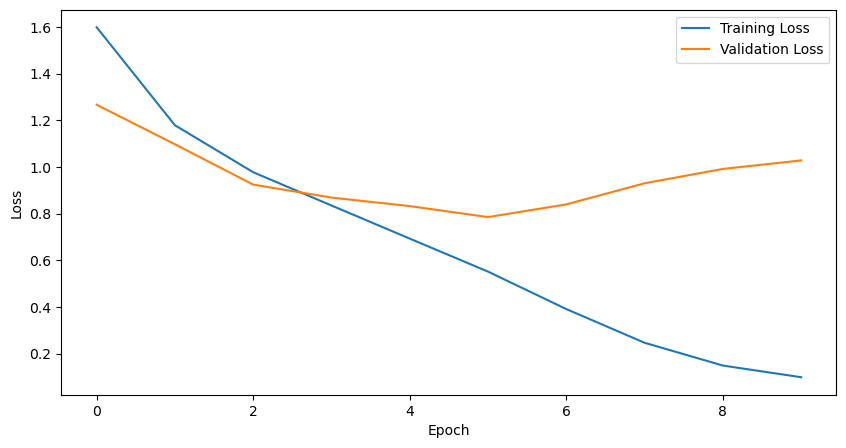

In [330]:
optim = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=10)
loss_fn = nn.CrossEntropyLoss()


train_model(model, optim, loss_fn, train_dl, valid_dl, scheduler=scheduler, epochs=10, valid_every=1)

In [358]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation: nn.Module = nn.ReLU, kernel_size: int = 3, stride: int = 1, padding: int = 1):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding), 
            nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.BatchNorm2d(out_channels),
            activation()
        )

    def forward(self, x):
        return self.conv(x)

class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation: nn.Module = nn.ReLU, kernel_size: int = 3, stride: int = 1, padding: int = 1):
        super().__init__()
        self.conv1 = ConvBlock(in_channels, out_channels, activation, kernel_size, stride)
        self.idconv = nn.Identity() if in_channels == out_channels else nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride)
        self.pool = nn.Identity() if in_channels == out_channels else nn.AvgPool2d(stride)

    def forward(self, x):
        h = self.conv1(x)
        h_pool = self.pool(x)
        print(h_pool.shape)
        h_id = self.idconv(h_pool)
        print(h.shape, h_id.shape)
        return h + h_id


In [359]:
res_block = ResBlock(3, 64).to(device)
print(x_train[0].shape)
res_block(x_train[0].unsqueeze(0)).shape

torch.Size([3, 32, 32])
torch.Size([1, 3, 32, 32])
torch.Size([1, 64, 32, 32]) torch.Size([1, 64, 32, 32])


torch.Size([1, 64, 32, 32])

In [ ]:
class ResNet(nn.Module):
    def __init__(self, num_channels: int, num_classes: int, filters: list[int], activation: nn.Module = nn.ReLU):
        super().__init__()
        conv_layers = [
            nn.Conv2d(num_channels, filters[0], kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(filters[0]),
            activation()
        ]
        for i in range(len(filters)-1):
            conv_layers += [
                ResBlock(filters[i], filters[i+1], activation)
            ]
        
        conv_layers.append(nn.Conv2d(filters[-1], num_classes, kernel_size=3, stride=1, padding=1))
        self.conv_layers = nn.Sequential(*conv_layers)
        self.flatten = nn.Flatten()

    def forward(self, x):
        h = self.conv(x)
        h = self.res_blocks(h)
        h = self.flatten(h)
        return self.fc(h)

